# ASL Classification

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.16.1


## Import the Dataset

In [2]:
BATCH_SIZE = 4096
IMG_SIZE = (64, 64)

dataset = image_dataset_from_directory(
    "/kaggle/input/sign-language-detection-using-images/data",
    image_size=IMG_SIZE,  # Resize images to this size
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # One-hot encode the labels (suitable for classification)
    shuffle=True  # Shuffle the dataset
)

Found 42000 files belonging to 35 classes.


## Explore the data

In [3]:
for images, labels in dataset.take(1):
    print(images.shape)
    print(labels.shape)
# Número de batches
len(dataset)

(4096, 64, 64, 3)
(4096, 35)


11

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

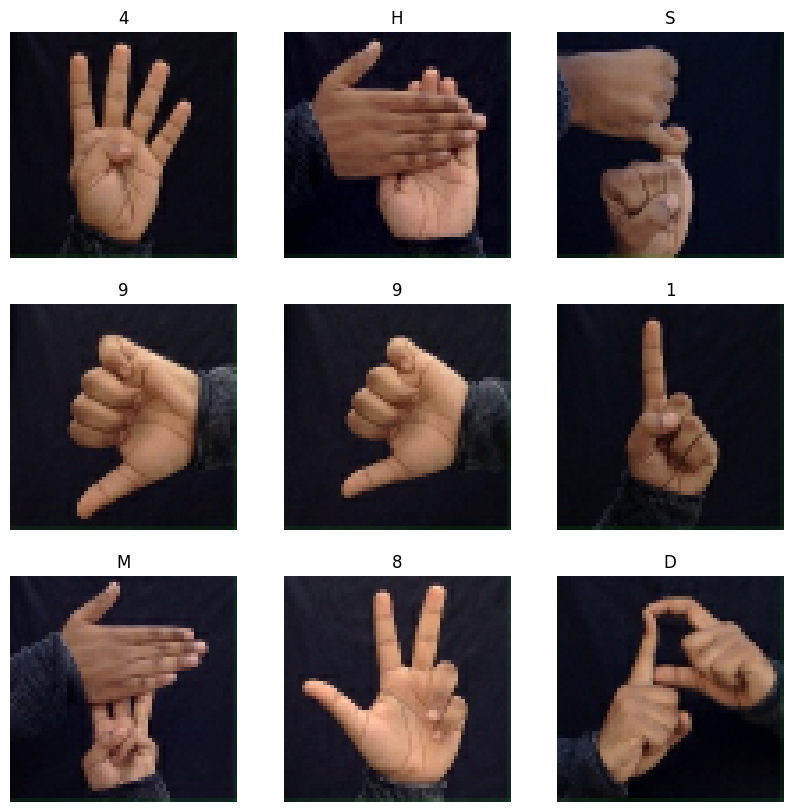

In [4]:
class_names = dataset.class_names
num_classes = len(class_names)

image_batch, label_batch = next(iter(dataset))

def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")

plot_images(image_batch, label_batch, class_names)
plt.show()

In [5]:
image_batch[0]

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[ 5.75,  4.75, 10.75],
        [ 7.5 ,  6.5 , 12.5 ],
        [ 9.5 ,  8.5 , 16.5 ],
        ...,
        [12.25, 10.75, 20.25],
        [ 9.75, 13.25, 15.75],
        [12.75, 30.75, 19.75]],

       [[ 4.  ,  5.  , 10.  ],
        [ 5.  ,  6.  , 11.  ],
        [11.  , 11.  , 19.  ],
        ...,
        [12.  , 10.25, 20.5 ],
        [11.5 , 14.5 , 18.5 ],
        [13.25, 31.  , 20.75]],

       [[ 4.25,  5.25, 10.25],
        [ 5.25,  6.25, 11.25],
        [ 8.5 ,  8.5 , 16.5 ],
        ...,
        [12.5 , 10.5 , 21.5 ],
        [11.5 , 13.75, 19.25],
        [15.5 , 33.  , 24.  ]],

       ...,

       [[10.  ,  7.5 , 15.25],
        [10.75,  8.75, 16.25],
        [10.  ,  8.  , 15.5 ],
        ...,
        [10.  ,  8.5 , 19.75],
        [ 9.75, 12.  , 17.5 ],
        [ 9.75, 26.25, 19.  ]],

       [[ 8.25,  9.75, 15.25],
        [ 7.5 ,  9.  , 14.5 ],
        [ 8.  ,  9.5 , 15.  ],
        ...,
        [10.  ,  9.  , 1

In [6]:
def preprocess(image, label=None):
    image = tf.cast(image, tf.float32) / 255.0  # Scale pixel values to 0-1
    if label is None:
        return image  # For test set (no labels)
    return image, label

In [7]:
num_samples = tf.data.experimental.cardinality(dataset).numpy()
print(f"Total samples: {num_samples}")

# Calculate the sizes for each split
train_size = int(num_samples * 0.7)  # 70% for training
val_size = int(num_samples * 0.15)    # 15% for validation
test_size = num_samples - train_size - val_size  # Remaining 15% for testing

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)

val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

Total samples: 11


In [8]:
# Apply the preprocessing to the datasets
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [9]:
image_batch, label_batch = next(iter(train_dataset))
image_batch[0]

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.02352941, 0.01960784, 0.04313726],
        [0.03529412, 0.03137255, 0.0627451 ],
        [0.04215686, 0.0382353 , 0.06960785],
        ...,
        [0.05686275, 0.04901961, 0.09215686],
        [0.04901961, 0.05882353, 0.08627451],
        [0.05588235, 0.1245098 , 0.09313726]],

       [[0.02058824, 0.01666667, 0.04019608],
        [0.03039216, 0.02647059, 0.05      ],
        [0.04411765, 0.04019608, 0.07156863],
        ...,
        [0.04901961, 0.04117647, 0.08431373],
        [0.04901961, 0.05882353, 0.08627451],
        [0.05392157, 0.12254902, 0.09117647]],

       [[0.02058824, 0.01666667, 0.04019608],
        [0.02843137, 0.0245098 , 0.04803922],
        [0.04313726, 0.03921569, 0.07058824],
        ...,
        [0.05490196, 0.04803922, 0.0882353 ],
        [0.05490196, 0.06470589, 0.09215686],
        [0.07058824, 0.1392157 , 0.10784314]],

       ...,

       [[0.03137255, 0.03333334, 0.05294118],
        [0.0303

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

cnn = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  
])

model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,
    cnn
])

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Se cambia porque está one-hot encoded
              metrics=[tf.keras.metrics.F1Score(average='weighted'),'accuracy'],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 35)             │     1,630,435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,630,435 (6.22 MB)

 Trainable params: 1,630,435 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.0319 - f1_score: 0.0098 - loss: 3.5163 - val_accuracy: 0.0818 - val_f1_score: 0.0341 - val_loss: 3.2586
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.0805 - f1_score: 0.0506 - loss: 3.2717 - val_accuracy: 0.1575 - val_f1_score: 0.1118 - val_loss: 2.8722
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.1569 - f1_score: 0.1158 - loss: 2.9901 - val_accuracy: 0.3406 - val_f1_score: 0.2495 - val_loss: 2.4840
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.2372 - f1_score: 0.1958 - loss: 2.7244 - val_accuracy: 0.4419 - val_f1_score: 0.3745 - val_loss: 2.1755
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.3307 - f1_score: 0.2943 - loss: 2.4123 - val_accuracy: 0.4863 - val_f1_score: 0.4202 - val_loss: 1.7825
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.4087 - f1_score: 0.3675 - loss: 2.1161 - val_accuracy: 0.6084 - val_f1_score: 0.5343 - val_l

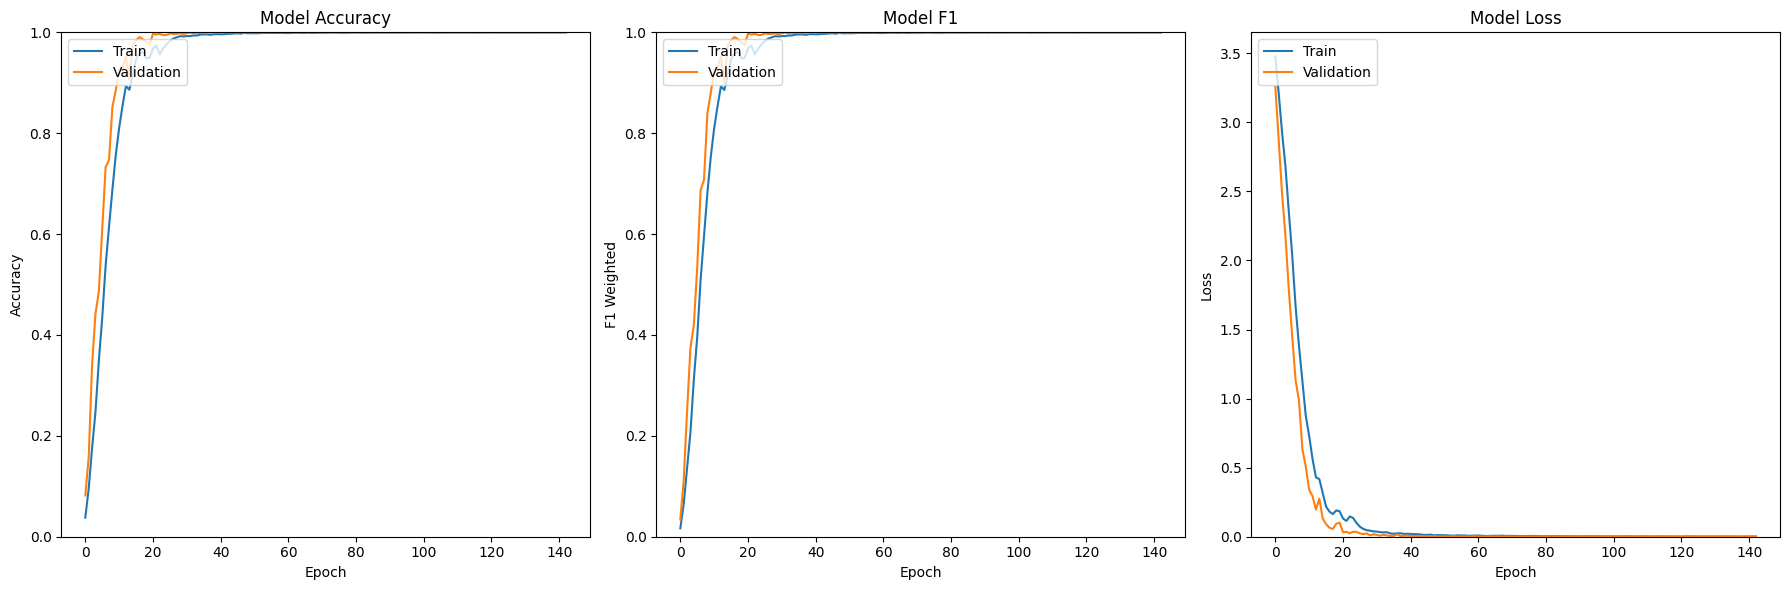

In [14]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.set_ylim([0,1])

# Plot training & validation accuracy values
ax2.plot(history.history['f1_score'])
ax2.plot(history.history['val_f1_score'])
ax2.set_title('Model F1')
ax2.set_ylabel('F1 Weighted')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.set_ylim([0,1])

# Plot training & validation loss values
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('Model Loss')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['Train', 'Validation'], loc='upper left')
ax3.set_ylim(bottom=0)

# Show the plots
plt.tight_layout()
plt.show()

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

In [15]:
val_loss, val_f1, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation F1 by Class: {val_f1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 2.1478e-04
Validation Loss: 0.00021478344569914043
Validation Accuracy: 1.0
Validation F1 by Class: 1.0


In [16]:
test_loss, test_f1, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 by Class: {test_f1}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 924ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 2.4161e-04
Test Loss: 0.0002543768205214292
Test Accuracy: 1.0
Test F1 by Class: 1.0


In [17]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [18]:
images, labels = next(iter(test_dataset))
predictions = model.predict(images)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [19]:
predicted_labels_idx = np.argmax(predictions, axis=1)
labels = np.argmax(labels, axis=1)

Text(0.5, 1.0, 'Label: H | Prediction: H')

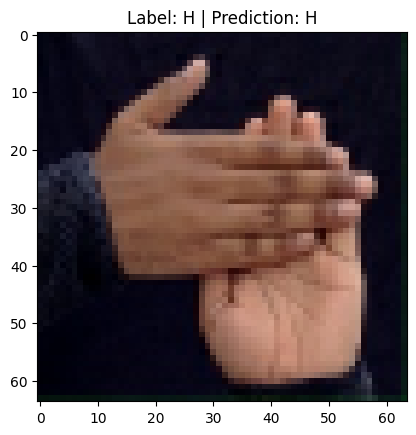

In [20]:
plt.imshow(images[0])
plt.title(f"Label: {class_names[labels[0]]} | Prediction: {class_names[predicted_labels_idx[0]]}")

Para esta actividad, tanto para el modelo LeNet como otros tipos de redes convolucionales, tuve una gran lección sobre la calidad y variabilidad de los datos. En especifico para este notebook, trabajé con un dataset con fotos de manos haciendo señales de ASL, siendo el lenguaje de señas de estados unidos. Al explorar este encontre que las fotos diferían significativamente entre clases, y bien no habia mucha varianza dentro de cada clase. Si bien esto hacía que fuera más sencillo de entrenar una red con estos datos, el mostrar nuevos datos al modelo podría resultar en predicciones erroneas. Por lo tanto, se optó por incluir un codigo de aumentación de datos para generar más variabilidad en las imagenes, sin comprometer el rendimiento del modelo. Al momento de entrenar el modelo, corroboré la distribución de las probabilidades obtenidas por la capa softmax. Noté que la diferencia entre la predicción principal y el resto de las clases era poca, pero esto hace sentido porque mientras más clases se tengan más dificil será que el modelo logre discriminar con considerable certeza entre clases. En cuanto al modelo, resultó que el modelo LeNet logró distinguir con excelentes resultados las diferentes letras del lenguaje de señas, obteniendo un F1 de 99.9% para datos que nunca había visto (test dataset). Al momento de probar diferentes arquitecturas, se buscó reducir la complejidad del modelo para tener menos parametros de entrenamiento y a la vez no caer en el subajuste. 